In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import os
import cv2

Скрин сабмита на кагле, тут видно ник

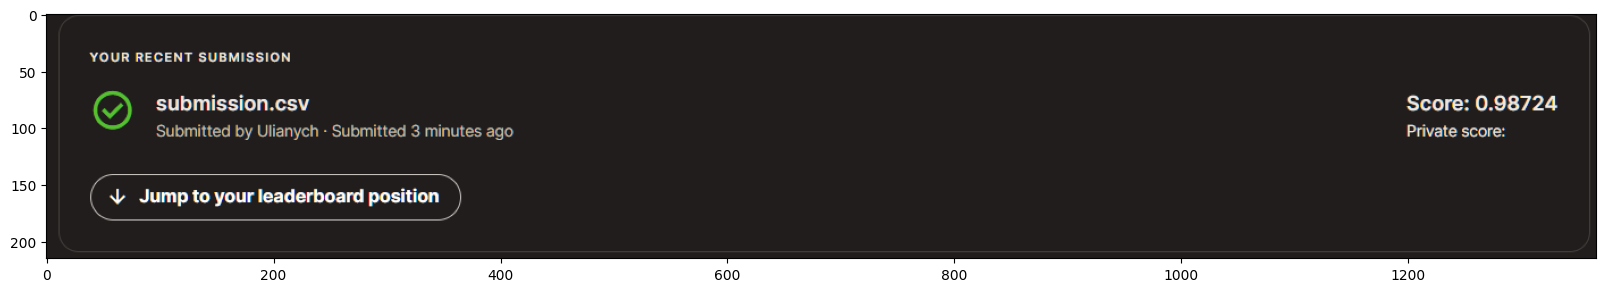

In [3]:
img = cv2.imread('/content/Screenshot 2024-04-15 222252.png')
fig = plt.figure(figsize=(20, 10))
plt.imshow(img)
plt.show()

In [ ]:
import warnings
warnings.filterwarnings("ignore")

Посмотрим на наш датасет, заметим, что размер картинок 350х350

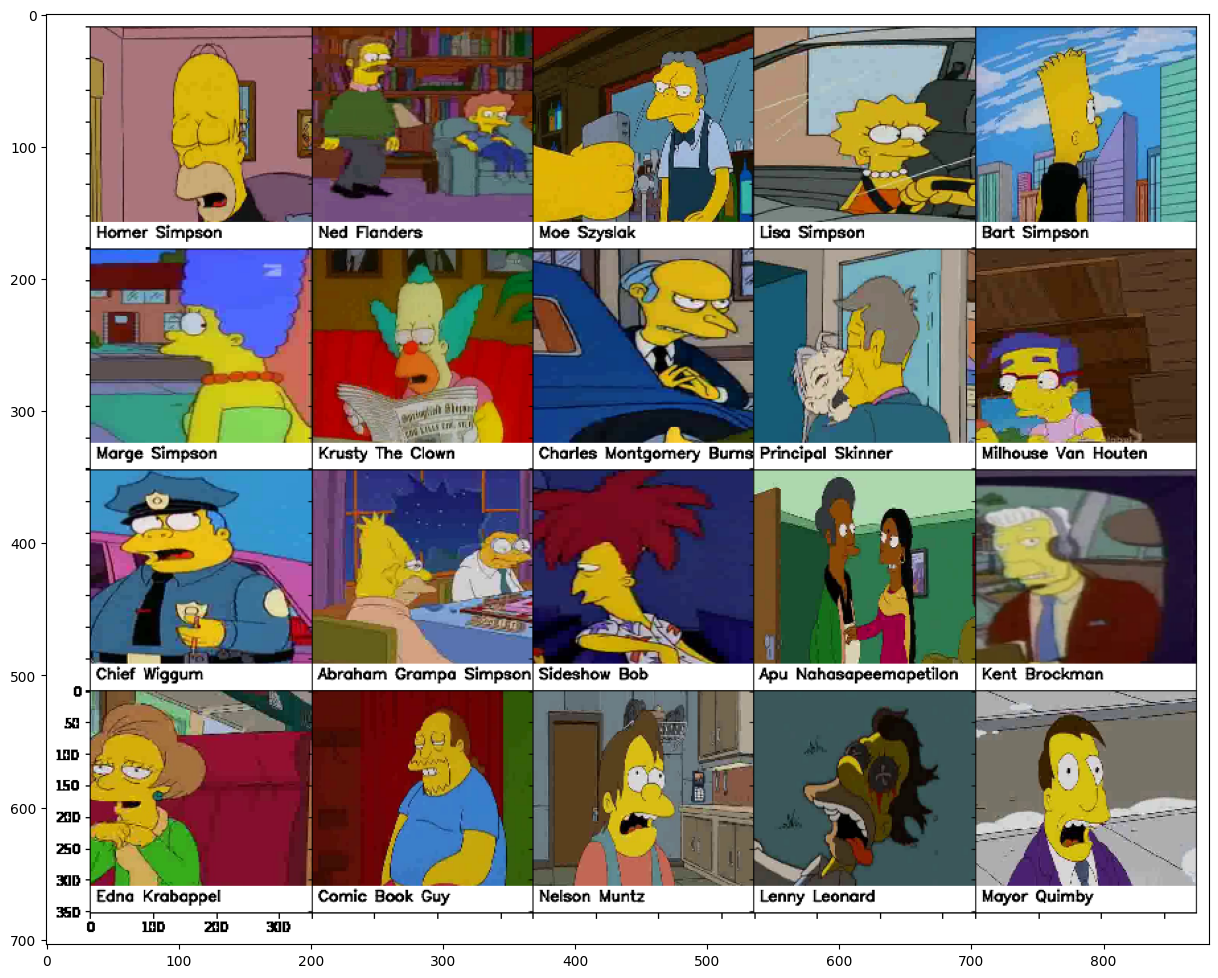

In [ ]:
image_path = '/kaggle/input/journey-springfield/characters_illustration.png'

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(15,15))
plt.imshow(image)

Создадим массив классов

In [ ]:
data_dir = "/kaggle/input/journey-springfield/train/simpsons_dataset"
class_names = os.listdir(data_dir)

Функция для получения путей к изображениям и соответствующих им лейблам

In [ ]:
def get_data(data_dir):
    image_path = []
    labels = []
    for class_name in class_names:
        class_dir = os.path.join(data_dir, class_name)
        for image_name in os.listdir(class_dir):
            image = os.path.join(class_dir, image_name)
            image_path.append(image)
            labels.append(class_name)

    return image_path, labels

Получаем данные и сразу кодируем, чтобы можно было по предиктам восстановить названия классов

In [ ]:
images, labels = get_data(data_dir)

encoded_labels = {class_names[i]: i for i in range(0, len(class_names))}

y = [encoded_labels[key] for key in labels]

X_train, X_test, y_train, y_test = train_test_split(images, y, test_size=0.2, stratify=y)

Для того, чтобы определить параметры нормализации, которые будем использовать в аугментации, посчитаем среднее значение яркости и среднее отклонение по всем изображениям

In [ ]:
def see_info(images_path):
    means = []
    stds = []

    for path in images_path:

        image = cv2.imread(path)
        image = image[:, :, ::-1]

        means.append(image.mean(axis =(0,1)))
        stds.append(image.std(axis =(0,1)))

    return {
          'channel mean' : np.array(means).mean(axis=0),
          'channel std' : np.array(stds).mean(axis=0),
          }

In [ ]:
info = see_info(images)
means = info['channel mean']
stds = info['channel std']

In [ ]:
channel_mean = np.array(means).mean(axis=0)
channel_std = np.array(stds).mean(axis=0)

print(channel_mean / 255, channel_std/ 255)

0.4073783113022503 0.21246458480824065


In [ ]:
from torchvision.transforms import RandomHorizontalFlip, Normalize, Resize, Compose, RandomCrop, ToTensor, ToPILImage, CenterCrop, GaussianBlur, RandomRotation

from torchvision import datasets, transforms

In [ ]:
class SimpsonDataset(Dataset):
    def __init__(self, images, labels, transform):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        label = self.labels[idx]
        image_path = self.images[idx]

        image = cv2.imread(image_path)

        if self.transform:
            image = self.transform(image)

        return image, label


Поскольку имеем дело с картинками из мультфильма, то сильные преобразования в аугментацию передавать не будем, чтобы train сильно не отличался от теста. Достаточно будет зеркального отражения

In [ ]:
transform = Compose([ToTensor(),
                     Resize((256, 256)),
                     RandomHorizontalFlip(p=0.5),
                     #RandomRotation(degrees=(-25,25)),
                     #RandomCrop((224, 224)),
                     Normalize(channel_mean / 255, channel_std / 255)
                     ])

In [ ]:
transform_test = Compose([ToTensor(),
                         Resize((256, 256)),
                         Normalize(channel_mean / 255, channel_std / 255),
])

In [ ]:
train_data = SimpsonDataset(X_train, y_train, transform)
test_data = SimpsonDataset(X_test, y_test, transform_test)

In [ ]:
train_loader = DataLoader(train_data, batch_size=8, shuffle=True, drop_last=True)
val_loader = DataLoader(test_data, batch_size=8, shuffle=False, drop_last=False)

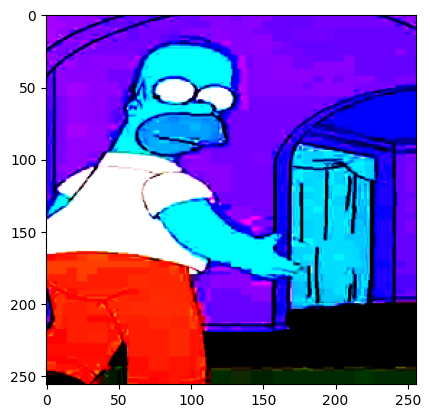

In [ ]:
plt.imshow(train_data[0][0].permute(1, 2, 0))

In [ ]:
from torchvision import models
import torch.optim as optim

In [ ]:
from sklearn.metrics import f1_score

Эксперементальным путем было выяснено, что сильно глубокая сеть не требуется, поэтому возьмем resnet50 и дообучим на наших данных. <br>
Также необходимо переписать выходной слой, так как на resnet выход 1000, а нам нужно около 40

In [ ]:
model = models.resnet50(pretrained=True)

num_classes = len(class_names)
num_ftrs = model.fc.in_features

model.fc = nn.Sequential(nn.Linear(num_ftrs, 256),
                        nn.BatchNorm1d(256),
                        nn.ReLU(),
                        nn.Linear(256, 128),
                        nn.BatchNorm1d(128),
                        nn.ReLU(),
                        nn.Linear(128, num_classes),
                        )

for param in model.parameters():
    param.requires_grad = True

#for param in model.fc.parameters():
#    param.requires_grad = True

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

model = model.to('cuda')

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 159MB/s]


In [ ]:
def train_epoch(model, optimizer, criteria, train_loader):
    model.train()
    losses = []
    metrics = []
    for batch in tqdm(train_loader):
        X, y = batch
        X = X.to('cuda')
        y = y.to('cuda')
        probabilities = model(X)
        #probabilities.detach().cpu()
        loss = criteria(probabilities, y)
        losses.append(loss.detach().cpu())
        probabilities = probabilities.detach().cpu().numpy()
        y = y.detach().cpu().numpy()
        f1 = f1_score(y, np.argmax(probabilities, axis=1), average='micro')
        metrics.append(f1)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return np.array(losses).mean(), np.array(metrics).mean()

@torch.no_grad()
def eval_epoch(model, criteria, val_loader):
    model.eval()
    losses = []
    metrics = []

    for batch in tqdm(val_loader):
        X, y = batch
        X = X.to('cuda')
        y = y.to('cuda')
        probabilities = model(X)
        #probabilities.detach().cpu()
        loss = criteria(probabilities, y)
        losses.append(loss.detach().cpu())
        probabilities = probabilities.detach().cpu().numpy()
        y = y.detach().cpu().numpy()
        f1 = f1_score(y, np.argmax(probabilities, axis=1), average='micro')
        metrics.append(f1)

    return np.array(losses).mean(), np.array(metrics).mean()

In [ ]:
from tqdm import tqdm

In [ ]:
torch.cuda.empty_cache()

In [ ]:
n_epochs = 8
losses = []
metrics = []
for epoch in range(n_epochs):
    loss_train, metrics_train = train_epoch(model, optimizer, criterion, train_loader)
    loss_val, metrics_val = eval_epoch(model, criterion, val_loader)
    print('Epoch: ', epoch+1)
    print('Loss train: ', loss_train)
    print('F1 train: ', metrics_train)
    print('Loss val: ', loss_val)
    print('F1 val: ', metrics_val)
    losses.append(loss_val)
    metrics.append(metrics_val)

100%|██████████| 524/524 [00:32<00:00, 15.96it/s]


Epoch:  1
Loss train:  1.0757691
F1 train:  0.802675585284281
Loss val:  0.42796344
F1 val:  0.9084764631043257


100%|██████████| 524/524 [00:32<00:00, 15.93it/s]


Epoch:  2
Loss train:  0.4294951
F1 train:  0.9133420926899187
Loss val:  0.29799625
F1 val:  0.9320133587786259


100%|██████████| 524/524 [00:32<00:00, 16.08it/s]


Epoch:  3
Loss train:  0.30940363
F1 train:  0.9322742474916388
Loss val:  0.22579321
F1 val:  0.9451335877862596


100%|██████████| 524/524 [00:33<00:00, 15.85it/s]


Epoch:  4
Loss train:  0.23918317
F1 train:  0.9464285714285714
Loss val:  0.21333088
F1 val:  0.9494274809160306


100%|██████████| 524/524 [00:32<00:00, 16.05it/s]


Epoch:  5
Loss train:  0.19158079
F1 train:  0.9566411849020545
Loss val:  0.1880801
F1 val:  0.950381679389313


100%|██████████| 524/524 [00:32<00:00, 15.96it/s]


Epoch:  6
Loss train:  0.16481298
F1 train:  0.9612398471094123
Loss val:  0.18915005
F1 val:  0.9534828244274809


100%|██████████| 524/524 [00:32<00:00, 16.10it/s]


Epoch:  7
Loss train:  0.13506423
F1 train:  0.9672718585762065
Loss val:  0.21586789
F1 val:  0.9470419847328244


100%|██████████| 524/524 [00:32<00:00, 15.89it/s]

Epoch:  8
Loss train:  0.118324675
F1 train:  0.9711538461538461
Loss val:  0.15626062
F1 val:  0.9611164122137404


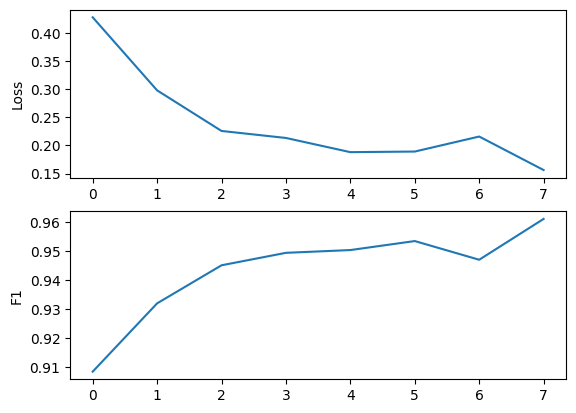

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1)

ax1.plot(range(n_epochs), losses)
ax1.set_ylabel('Loss')

ax2.plot(range(n_epochs), metrics)
ax2.set_ylabel('F1')

plt.show()

In [ ]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            X = inputs[0]
            X = X.to('cuda')
            model.eval()
            outputs = model(X).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [ ]:
my_submit = pd.read_csv('/kaggle/input/journey-springfield/sample_submission.csv')
my_submit.head()

,Id,Expected
0,img0.jpg,bart_simpson
1,img1.jpg,bart_simpson
2,img2.jpg,bart_simpson
3,img3.jpg,bart_simpson
4,img4.jpg,bart_simpson


In [ ]:
test_dir = '/kaggle/input/journey-springfield/testset/testset'

In [ ]:
image_test = []
labels = []
for image_name in os.listdir(test_dir):
    image = os.path.join(test_dir, image_name)
    image_test.append(image)
    labels.append(image_name)

In [ ]:
test = SimpsonDataset(image_test, labels, transform_test)
test_loader = DataLoader(test, batch_size=32, shuffle=False, drop_last=False)

In [ ]:
probs = predict(model, test_loader)

In [ ]:
probs = np.argmax(probs, axis=1)

In [ ]:
preds = [class_names[idx] for idx in probs]

In [ ]:
test_filenames = os.listdir('/kaggle/input/journey-springfield/testset/testset')

In [ ]:
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.to_csv('/kaggle/working/submission.csv', index=False)